<a href="https://colab.research.google.com/github/Furkanpusher/U-NET/blob/main/%C4%B0mproved_UNET.%20with%20REAL%20BLUR%20DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
!nvidia-smi

Wed Apr 30 15:36:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


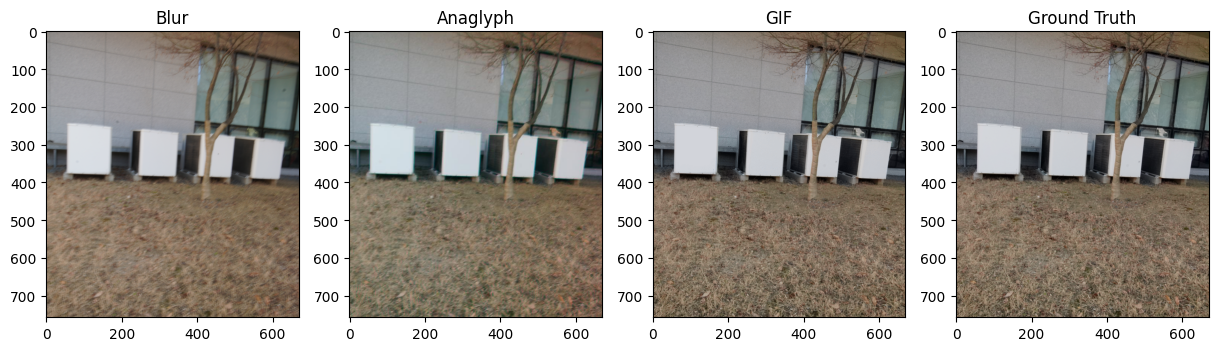

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Örnek bir sahne (scene001)
base_path = "/content/drive/MyDrive/RealBlur_Dataset/RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene001"
img_blur = Image.open(f"{base_path}/blur/blur_10.png")  # Dosya adını tahmin ettim, seninkine göre uyarla   /content/drive/MyDrive/RealBlur_Dataset/RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene001/blur/blur_1.png
img_anaglyph = Image.open(f"{base_path}/Anaglyph/Anaglyph_10.jpg")
img_gif = Image.open(f"{base_path}/gif/gif_10.gif")
img_gt = Image.open(f"{base_path}/gt/gt_10.png")

# Görüntüleri yan yana göster
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1), plt.imshow(img_blur), plt.title("Blur")
plt.subplot(1, 4, 2), plt.imshow(img_anaglyph), plt.title("Anaglyph")
plt.subplot(1, 4, 3), plt.imshow(img_gif), plt.title("GIF")
plt.subplot(1, 4, 4), plt.imshow(img_gt), plt.title("Ground Truth")
plt.show()

# AUGMENTASYON EKLENDİ

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms
import torch

# Bellek yönetimini optimize et
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Eğitim için augmentasyonlu transform
train_transform = transforms.Compose([
    transforms.RandomCrop((640, 640)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01)
])

# Test için augmentasyonsuz transform
test_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

class RealBlurDataset(Dataset):
    def __init__(self, root_dir, scene_list, blur_type="blur", transform=None):
        self.root_dir = root_dir
        self.blur_type = blur_type
        self.transform = transform
        self.image_pairs = []
        for scene in scene_list:
            # blur ve gt klasörleri direkt sceneXXX altında
            blur_dir = os.path.join(root_dir, f"scene{scene:03d}/{blur_type}")
            gt_dir = os.path.join(root_dir, f"scene{scene:03d}/gt")
            for i in range(1, 22):  # 1.png - 21.png
                blurry = os.path.join(blur_dir, f"blur_{i}.png")  # blur_1.png, blur_2.png, ..., blur_21.png
                sharp = os.path.join(gt_dir, f"gt_{i}.png")  # 1.png, 2.png, ..., 21.png
                if os.path.exists(blurry) and os.path.exists(sharp):
                    self.image_pairs.append((blurry, sharp))
                else:
                    print(f"Eksik dosya: {blurry} veya {sharp}")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        blurry_path, sharp_path = self.image_pairs[idx]
        blurry_img = Image.open(blurry_path).convert("RGB")
        sharp_img = Image.open(sharp_path).convert("RGB")
        if self.transform:
            blurry_img = self.transform(blurry_img)
            sharp_img = self.transform(sharp_img)
        return blurry_img, sharp_img

# Eğitim ve test dataset'leri
train_dataset = RealBlurDataset(
    root_dir="/content/drive/MyDrive/RealBlur_Dataset/RealBlur-J_ECC_IMCORR_centroid_itensity_ref",  # Doğru root dizini
    scene_list=range(1, 201),
    blur_type="blur",
    transform=train_transform
)
test_dataset = RealBlurDataset(
    root_dir="/content/drive/MyDrive/RealBlur_Dataset/RealBlur-J_ECC_IMCORR_centroid_itensity_ref",  # Doğru root dizini
    scene_list=range(201, 235),
    blur_type="blur",
    transform=test_transform
)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


Eksik dosya: /content/drive/MyDrive/RealBlur_Dataset/RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene075/blur/blur_21.png veya /content/drive/MyDrive/RealBlur_Dataset/RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene075/gt/gt_21.png


In [ ]:
from numpy import load

# .npz dosyasını yükle
data = load('/content/drive/MyDrive/gopro_dataset.npz')

# Verileri ayrı değişkenlere aktar
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']

# Kontrol amaçlı şekilleri yazdır
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (2103, 640, 640, 3)
y_train shape: (2103, 640, 640, 3)
x_test shape: (1111, 640, 640, 3)
y_test shape: (1111, 640, 640, 3)


In [ ]:
x_train = torch.tensor(data=x_train, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (B, C, H, W)
y_train = torch.tensor(data=y_train, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
x_test = torch.tensor(data=x_test, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
y_test = torch.tensor(data=y_test, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0

In [ ]:
assert x_train.shape == (2103, 3, 640, 640), f"x_train boyutu hatalı: {x_train.shape}"
assert y_train.shape == (2103, 3, 640, 640), f"y_train boyutu hatalı: {y_train.shape}"

In [ ]:
# ENCODER KISMI: MOBILENET
# SKIP CONNECTION: CBAM + STARNET
# BOTTLE NECK: STARNET
# OUTPUT KISMI: STARNET


import torch
import torch.nn as nn
from CBAM import CBAM
from STARNET_2D import STARNet2D
from unet_parts import UpSample
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import torch.nn.functional as F
from torchsummary import summary


class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # MobileNetV3 encoder
        self.encoder = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1).features

        # Bottleneck with STARNet2D
        self.bottle_neck = STARNet2D(in_channels=576, out_channels=1024, dim=1024, depth=2, use_stem = True, use_head = True)

        # Upsampling path
        self.up_convolution_1 = UpSample(1024, 512, 96)
        self.up_convolution_2 = UpSample(512, 256, 40)
        self.up_convolution_3 = UpSample(256, 128, 24)
        self.up_convolution_4 = UpSample(128, 64, 16)

        # Output layer
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

        # CBAM + STARNet modülleri burda
        self.cbam1 = nn.Sequential(
            CBAM(in_channels=16),
            STARNet2D(16, out_channels=16, depth=1, use_stem=False, use_head=False)
        )
        self.cbam2 = nn.Sequential(
            CBAM(in_channels=24),
            STARNet2D(24, out_channels=24, depth=1, use_stem=False, use_head=False)
        )
        self.cbam3 = nn.Sequential(
            CBAM(in_channels=40),
            STARNet2D(40, out_channels=40, depth=1, use_stem=False, use_head=False)
        )
        self.cbam4 = nn.Sequential(
            CBAM(in_channels=96),
            STARNet2D(96, out_channels=96, depth=2, use_stem=False, use_head=False)
        )

    # Output refinement ile son outputu vermeden resimdeki ufak iyileştirmeleri ypamak için hemde interpolasyondan oluşabilcek etkileride azaltır

        self.output_refiner = STARNet2D(num_classes, out_channels=num_classes, depth=1, dim=64)


    def forward(self, x):
        # Encoder
        skip_1, skip_2, skip_3, skip_4 = None, None, None, None
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            if i == 0: skip_1 = x
            elif i == 3: skip_2 = x
            elif i == 6: skip_3 = x
            elif i == 10: skip_4 = x

        # Bottleneck
        b = self.bottle_neck(x)

        # Decoder with enhanced skip connections
        down_4 = self.cbam4(skip_4)
        up_1 = self.up_convolution_1(b, down_4)

        down_3 = self.cbam3(skip_3)
        up_2 = self.up_convolution_2(up_1, down_3)

        down_2 = self.cbam2(skip_2)
        up_3 = self.up_convolution_3(up_2, down_2)

        down_1 = self.cbam1(skip_1)   # burdaki cbam1 ler içinde hem CBAM hemde STARNET VAR
        up_4 = self.up_convolution_4(up_3, down_1)

        # Final output
        out = self.out(up_4)
        out = F.interpolate(out, size = (640,640), mode='bilinear', align_corners=False)
        return self.output_refiner(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, num_classes=3).to(device)

input_tensor = torch.rand(1, 3, 640, 640).to(device)
with torch.no_grad():
    output = model(input_tensor)
    print(f"Çıkış boyutu: {output.shape}")  # [1, 3, 224, 224]

summary(model, input_size=(3, 640, 640), device=str(device))


# 31M parametre  NORMALDE 25.8m dı STARNET ile 31M parametre oldu

Cbam öncesi shape:torch.Size([1, 64, 56, 56])
Cbam sonrası shape:torch.Size([1, 64, 56, 56])
torch.Size([1, 1000])
Cbam öncesi shape:torch.Size([2, 64, 56, 56])
Cbam sonrası shape:torch.Size([2, 64, 56, 56])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Conv2d-6              [-1, 4, 1, 1]             256
              ReLU-7              [-1, 4, 1, 1]               0
            Conv2d-8             [-1, 64, 1, 1]             256
 AdaptiveMaxPool2d-9             [-1, 64, 1, 1]               0
           Conv2d-10              [-1, 4, 1, 1]             256
             ReLU-11   

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 178MB/s]


Çıkış boyutu: torch.Size([1, 3, 640, 640])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 320, 320]             432
       BatchNorm2d-2         [-1, 16, 320, 320]              32
         Hardswish-3         [-1, 16, 320, 320]               0
            Conv2d-4         [-1, 16, 160, 160]             144
       BatchNorm2d-5         [-1, 16, 160, 160]              32
              ReLU-6         [-1, 16, 160, 160]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12         [-1, 16, 160, 160]               0
           Conv2d-13         [-1, 16, 160, 160]             

rm: cannot remove '/root/.cache/torch/hub/checkpoints/multilingual_debiased-0b549669.ckpt': No such file or directory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvi

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)  # Modelinizi buraya ekleyin


pretrained_weights_path = '/content/best (1).pth'

try:
    model = torch.load(pretrained_weights_path, map_location=device)
    print("Tüm model başarıyla yüklendi.")
except Exception as e:
    print(f"Tüm model yüklenirken hata: {e}")

# Eğer state_dict kaydedildiyse
try:
    model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))
    print("State dict başarıyla yüklendi.")
except Exception as e:
    print(f"State dict yüklenirken hata: {e}")


Tüm model yüklenirken hata: PytorchStreamReader failed reading zip archive: failed finding central directory
State dict yüklenirken hata: PytorchStreamReader failed reading zip archive: failed finding central directory


In [ ]:
import numpy as np
from torch.nn import MSELoss
from pytorch_msssim import SSIM
import torch
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)  # Modelinizi buraya ekleyin

# Önceden eğitilmiş ağırlıkları yükle
pretrained_weights_path = "/content/son_best.pth"  # Ağırlık dosyasının yolunu kontrol edin
if os.path.exists(pretrained_weights_path):
    print(f"Dosya bulundu: {pretrained_weights_path}")
    print(f"Dosya boyutu: {os.path.getsize(pretrained_weights_path) / (1024 * 1024):.2f} MB")
    try:
      data = torch.load(pretrained_weights_path, map_location="cpu")
      print("Dosya başarıyla açıldı. İçerik:", list(data.keys())[:5])  # İlk 5 anahtarı göster
    except Exception as e:
      print(f"Dosya açılırken hata: {e}")
else:
    print(f"Ağırlık dosyası bulunamadı: {pretrained_weights_path}. Sıfırdan eğitime devam ediliyor.")

# Önceki ağırlıkları (GoPro’dan gelen) kaydet
old_params = {name: param.clone().detach() for name, param in model.named_parameters()}

# Fisher Information’ı basitçe birim matris olarak varsay
fisher_diag = {name: torch.ones_like(param) for name, param in model.named_parameters()}

# EWC hiperparametresi
lambda_ewc = 0.4

optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
mse_loss = MSELoss()
ssim_loss = SSIM(data_range=1.0, size_average=True, channel=3)

def compute_ewc_loss(model, old_params, fisher_diag, lambda_ewc):
    ewc_loss = 0.0
    for name, param in model.named_parameters():
        if name in old_params:
            ewc_loss += (fisher_diag[name] * (param - old_params[name]) ** 2).sum()
    return lambda_ewc * ewc_loss

def test_loop(test_loader, model, epoch):
    model.eval()
    total_mse = 0.0
    total_ssim = 0.0
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (bulanik, kaliteli) in enumerate(test_loader):
            bulanik = bulanik.to(device, non_blocking=True)
            kaliteli = kaliteli.to(device, non_blocking=True)
            output = model(bulanik)
            assert output.shape == kaliteli.shape, f"Model çıktı boyutu hatalı: {output.shape} vs {kaliteli.shape}"
            mse = mse_loss(output, kaliteli)
            ssim = ssim_loss(output, kaliteli)
            ssim_loss_value = 1 - ssim
            loss = ALPHA * ssim_loss_value + BETA * mse
            total_mse += mse.item()
            total_ssim += ssim.item()
            total_loss += loss.item()
            num_batches += 1
            if batch_idx % 50 == 0:
                psnr = 10 * np.log10(1.0 / mse.item()) if mse.item() > 0 else float('inf')
                current_lr = optimizer.param_groups[0]['lr']
                print(f"[Test] Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.4f} | SSIM: {ssim.item():.4f} | PSNR: {psnr:.2f} dB | LR: {current_lr:.6f}")

    avg_mse = total_mse / num_batches
    avg_ssim = total_ssim / num_batches
    avg_loss = total_loss / num_batches
    avg_psnr = 10 * np.log10(1.0 / avg_mse) if avg_mse > 0 else float('inf')
    print(f"\n[Test Sonuçları] Epoch {epoch} | Avg Loss: {avg_loss:.4f} | Avg SSIM: {avg_ssim:.4f} | Avg PSNR: {avg_psnr:.2f} dB\n")
    return avg_loss

ALPHA = 0.7
BETA = 0.3
EPOCH = 16

for epoch in range(EPOCH):
    model.train()
    print(f"\nEpoch: {epoch+1}/{EPOCH}")
    for batch_idx, (bulanik, kaliteli) in enumerate(train_loader):
        bulanik = bulanik.to(device, non_blocking=True)
        kaliteli = kaliteli.to(device, non_blocking=True)
        output = model(bulanik)
        mse = mse_loss(output, kaliteli)
        ssim = ssim_loss(output, kaliteli)
        ssim_loss_value = 1 - ssim
        task_loss = ALPHA * ssim_loss_value + BETA * mse
        ewc_loss = compute_ewc_loss(model, old_params, fisher_diag, lambda_ewc)
        total_loss = task_loss + ewc_loss
        optimizer.zero_grad(set_to_none=True)
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if batch_idx % 100 == 0:
            psnr = 10 * torch.log10(1.0 / mse) if mse > 0 else float('inf')
            print(f"Batch {batch_idx} | Epoch: {epoch} | Total Loss: {total_loss.item():.4f} | Task Loss: {task_loss.item():.4f} | EWC Loss: {ewc_loss.item():.4f} | SSIM: {ssim.item():.4f} | PSNR: {psnr:.2f} dB")

    avg_val_loss = test_loop(test_loader, model, epoch)
    scheduler.step(avg_val_loss)
    torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

print("\nEğitim başarıyla tamamlandı!")

Dosya bulundu: /content/son_best.pth
Dosya boyutu: 3.00 MB
Dosya açılırken hata: PytorchStreamReader failed reading zip archive: failed finding central directory


NameError: name 'SSIM' is not defined

# 27 EPOCHDAN SONRA OVERFITTING BAŞLIYOR OLABİLİR

#  Ulaşılan değerler: SSIM: 0.7881 | PSNR: 24.14dB
#    Hedef değerler:    SSIM: 0.9300 | PSNR: 30.00dB

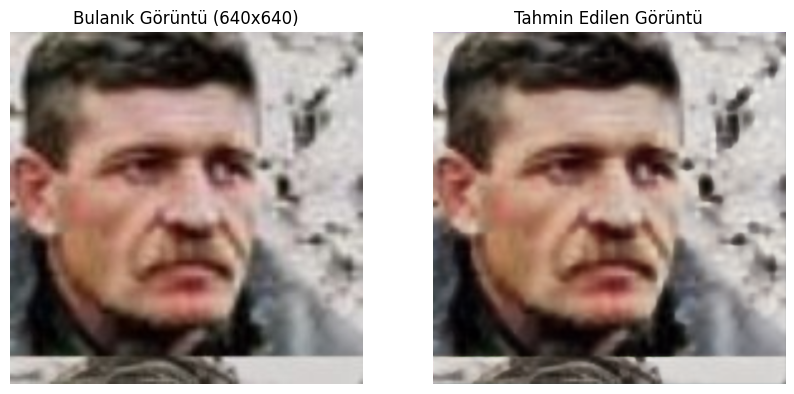

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, num_classes=3).to(device)

# Cihazı ayarla

# Tek bir görüntüyü yükle ve 640x640'a ayarla
bulanık_img_path = "/content/photo.jpg"  # Kendi bulanık görüntünüzün yolu

state_dict = torch.load('/content/best.pth', weights_only=True)  # weights_only=True ile yalnızca ağırlıkları al
model.load_state_dict(state_dict)  # Ağırlıkları modele yükle
model.eval()


bulanık_img = Image.open(bulanık_img_path).convert("RGB")

# Dönüşüm tanımla
transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Modelin beklediği boyuta göre ayarlandı
    transforms.ToTensor(),          # [0, 1] aralığına çevirir
])

# Orijinal görüntüyü 640x640 yap ve tensor'a çevir
bulanık_tensor = transform(bulanık_img).unsqueeze(0).to(device)  # [1, 3, 640, 640]
bulanık_img_resized = transforms.ToPILImage()(bulanık_tensor[0].cpu())  # 640x640 PIL görüntüsü

# Tahmin yap
with torch.no_grad():
    tahmin = model(bulanık_tensor)
    tahmin_img = tahmin[0].cpu().permute(1, 2, 0).numpy()  # [3, 640, 640] -> [640, 640, 3]

# Tahmin görüntüsünü 0-1 aralığına sabitle (gri ekranı önlemek için)
tahmin_img = np.clip(tahmin_img, 0, 1)

# Görselleştirme
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Bulanık Görüntü (640x640)")
plt.imshow(bulanık_img_resized)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Tahmin Edilen Görüntü")
plt.imshow(tahmin_img)
plt.axis("off")

plt.show()


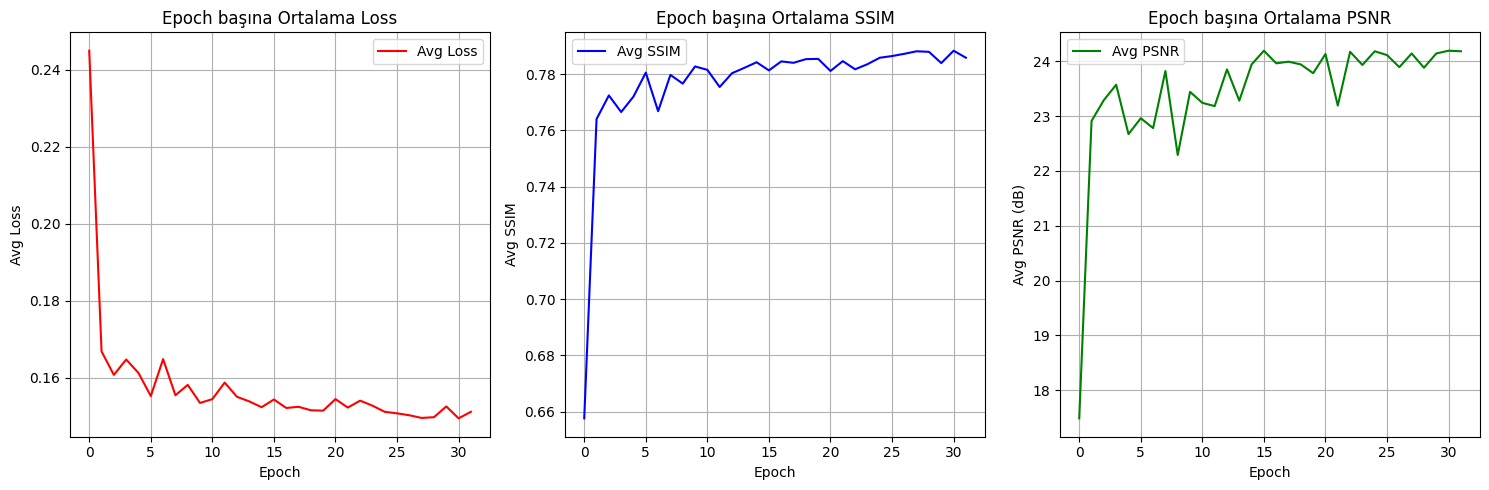

In [ ]:
import matplotlib.pyplot as plt

# Veriler (Test Sonuçları’ndan alındı)
epochs = list(range(32))
avg_loss = [
    0.2450, 0.1668, 0.1607, 0.1647, 0.1612, 0.1552, 0.1648, 0.1554, 0.1581, 0.1534,
    0.1544, 0.1587, 0.1550, 0.1538, 0.1523, 0.1543, 0.1521, 0.1524, 0.1515, 0.1514,
    0.1544, 0.1522, 0.1540, 0.1527, 0.1511, 0.1507, 0.1502, 0.1495, 0.1497, 0.1525,
    0.1494, 0.1511
]
avg_ssim = [
    0.6576, 0.7640, 0.7724, 0.7665, 0.7720, 0.7805, 0.7668, 0.7797, 0.7766, 0.7827,
    0.7815, 0.7754, 0.7803, 0.7822, 0.7842, 0.7813, 0.7845, 0.7840, 0.7853, 0.7854,
    0.7811, 0.7846, 0.7817, 0.7835, 0.7858, 0.7864, 0.7872, 0.7881, 0.7879, 0.7839,
    0.7883, 0.7858
]
avg_psnr = [
    17.49, 22.91, 23.29, 23.57, 22.67, 22.96, 22.78, 23.82, 22.29, 23.44,
    23.24, 23.18, 23.85, 23.28, 23.94, 24.19, 23.96, 23.99, 23.94, 23.78,
    24.13, 23.19, 24.17, 23.93, 24.18, 24.11, 23.89, 24.14, 23.88, 24.14,
    24.19, 24.18
]

# Grafik çizimi
plt.figure(figsize=(15, 5))

# Avg Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, avg_loss, label='Avg Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Avg Loss')
plt.title('Epoch başına Ortalama Loss')
plt.grid(True)
plt.legend()

# Avg SSIM
plt.subplot(1, 3, 2)
plt.plot(epochs, avg_ssim, label='Avg SSIM', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Avg SSIM')
plt.title('Epoch başına Ortalama SSIM')
plt.grid(True)
plt.legend()

# Avg PSNR
plt.subplot(1, 3, 3)
plt.plot(epochs, avg_psnr, label='Avg PSNR', color='green')
plt.xlabel('Epoch')
plt.ylabel('Avg PSNR (dB)')
plt.title('Epoch başına Ortalama PSNR')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()